In [1]:
# model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

class ConvAutoencoder:
  @staticmethod
  def build(width, height, depth, filters=(32, 64), latent_dim=16):

    # initialize input shape to be channels last along with channels dimension itself
    input_shape = (height, width, depth)
    chan_dim = -1

    # define input to encoder
    inputs = Input(shape=input_shape)
    x = inputs

    # loop over the number of filters
    for f in filters:
      # apply CONV => RELU => BN operations
      x = Conv2D(f, (3, 3), strides=2, padding='same')(x)
      x = LeakyReLU(alpha=0.2)(x)
      x = BatchNormalization(axis=chan_dim)(x)

    # flatten the network and then consturct our latent vector
    volume_size = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latent_dim)(x)

    # build the encoder model
    encoder = Model(inputs, latent, name='encoder')

    # start building the decoder model which will accept output of encoder as its input
    latent_input = Input(shape=(latent_dim,))
    x = Dense(np.prod(volume_size[1:]))(latent_input)
    x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)

    # loop over number of filters again but this time in reverse order
    for f in filters[::-1]:
      
      # apply a Conv_transpose => RELU => BN operation
      x = Conv2DTranspose(f, (3, 3), strides=2, padding='same')(x)
      x = LeakyReLU(alpha=0.2)(x)
      x = BatchNormalization(axis=chan_dim)(x)

    # apply a single Conv_Transpose layer used to recover the original depth of image
    x = Conv2DTranspose(depth, (3, 3), padding='same')(x)
    outputs = Activation('sigmoid')(x)

    # build decoder model
    decoder = Model(latent_input, outputs, name='decoder')

    # autoencoder is encoder + decoder
    autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

    return (encoder, decoder, autoencoder)

In [2]:
# training autoencoders

import matplotlib
matplotlib.use('Agg')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import random
import pickle

# Since we are doing unsupervised learning so we will build an unsupervised dataset
def build_unsupervised_dataset(data, labels, valid_label=1, anomaly_label=3, 
                               contam=0.01, seed=42):
  # grab all indexes of supplied class label that are truly that particular label
  # then grab the indexes of image labels that will serve as our anomalies
  valid_idxs = np.where(labels==valid_label)[0]
  anomaly_idxs = np.where(labels==anomaly_label)[0]

  # randomly shuffle both set of labels
  random.shuffle(valid_idxs)
  random.shuffle(anomaly_idxs)

  # compute the total number of anomaly data points to select
  i = int(len(valid_idxs) * contam)
  anomaly_idxs = anomaly_idxs[:i]

  # use numpy array indexing to extract both valid images and anomaly images
  valid_images = data[valid_idxs]
  anomaly_images = data[anomaly_idxs]

  # stack the valid images and anomaly images together to form a single data matrix and then
  # shuffle the rows
  images = np.vstack([valid_images, anomaly_images])
  np.random.seed(seed)
  np.random.shuffle(images)

  return images

# Function to help visualize predictions made by unsupervised autoencoder 
def visualize_prediction(decode, gt, samples=10):
  # initialize list of output images
  outputs = None

  # loop over our number of output samples
  for i in range(0, samples):
    # grab original image and reconstructed image
    original = (gt[i]*255).astype('uint8')
    recon = (decode[i]*255).astype('uint8')

    # stack original and reconstructed images side by side
    output = np.hstack([original, recon])

    # if the output array is empty, initialize it as the current side-by-side image display
    if outputs is None:
      outputs = output

    # otherwise vertically stack the output
    else:
      outputs = np.vstack([outputs, output])

  return outputs

# arguments
dataset = 'output/images.pickle'       # path to output dataset file
model_name = 'output/autoencoder.model'         # path to our output trained autoencoder
visu = "recon_vis.png"
plot = "plot.png"
epochs = 20
init_lr = 1e-3
batch_size = 32

# load mnist dataset
print('[INFO] loading MNIST dataset...')
((trainx, trainy), (testx, testy)) = mnist.load_data()

# build our unsupervised dataset with small amount of contamination added to it
print('[INFO] creating unsupervised dataset...')
images = build_unsupervised_dataset(trainx, trainy, valid_label=1, anomaly_label=3, contam=0.01)

# add a channel dimension to every image in dataset, and scale pixel intensities to range [0, 1]
images = np.expand_dims(images, axis=-1)
images = images.astype('float32')/255.0

# construct training and testing split
(trainX, testX) = train_test_split(images, test_size=0.2, random_state=42)

# construct our Conv autoencoder
print('[INFO] building autoencoder...')
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
autoencoder.compile(loss='mse', optimizer=opt)

# train convolution autoencoder
H=autoencoder.fit(trainX, trainX, validation_data=(testX, testX), epochs=epochs, 
                    batch_size=batch_size)



[INFO] loading MNIST dataset...
[INFO] creating unsupervised dataset...
[INFO] building autoencoder...
Epoch 1/20
171/171 [==============================] - 11s 28ms/step - loss: 0.0368 - val_loss: 0.0434
Epoch 2/20
171/171 [==============================] - 3s 20ms/step - loss: 0.0101 - val_loss: 0.0278
Epoch 3/20
171/171 [==============================] - 3s 20ms/step - loss: 0.0040 - val_loss: 0.0101
Epoch 4/20
171/171 [==============================] - 4s 21ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 5/20
171/171 [==============================] - 4s 21ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/20
171/171 [==============================] - 4s 23ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 7/20
171/171 [==============================] - 3s 19ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 8/20
171/171 [==============================] - 3s 19ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 9/20
171/171 [==============================] - 3s 18ms/step - loss: 0.0022 - val_

In [3]:
# use convolutional autoencoder to make predictions on testing images, construct the visualization, 
# and then save it to disk
print('[INFO] making predictions...')
decoded = autoencoder.predict(testX)
vis = visualize_prediction(decoded, testX)
cv.imwrite(visu, vis)

# construct a plot that plots and saves training history
N = np.arange(0, epochs)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='validation_loss')
plt.title('Training loss')
plt.xlabel('Epochs #')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.savefig(plot)

# serialize image data to disk
print('[INFO] saving image data...')
f = open(dataset, 'wb')
f.write(pickle.dumps(images))
f.close()

# serialize autoencoder model to disk
autoencoder.save(model_name, save_format='h5')

[INFO] making predictions...
[INFO] saving image data...


[INFO] loading autoencoder model and image data...
[INFO] MSE threshold: 0.02453741629421712
[INFO] outliers found: 7


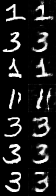

In [7]:
# finding anomalies
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
import numpy as np
import cv2 as cv
import pickle

dataset = 'output/images.pickle'
model = 'output/autoencoder.model'
quantile = 0.999

# load model and image data from disk
print('[INFO] loading autoencoder model and image data...')
autoencoder = load_model(model)
images = pickle.loads(open(dataset, 'rb').read())

# make predictions on our image data and initialize list of reconstruction errors
decoded = autoencoder.predict(images)
errors = []

# loop over the original image and their corresponding reconstructions
for (image, recon) in zip(images, decoded):
  
  # compute mean squared error between ground-truth image and reconstructed image and add it to
  # list of errors
  mse = np.mean((image - recon)**2)
  errors.append(mse)

# compute q-thquantile of errors which serves as our threshold to identify anomalies -- any data
# point that our model reconstructed with > threshold error will be marked as outlier
thresh = np.quantile(errors, quantile)
idxs = np.where(np.array(errors)>=thresh)[0]
print(f'[INFO] MSE threshold: {thresh}')
print(f'[INFO] outliers found: {len(idxs)}')

# initialize the outputs array
outputs = None

# loop over the indexes of images with a high mean squared error term
for i in idxs:
  
  # grab original image and reconstructed image side-by-side
  original = (images[i]*255).astype('uint8')
  recon = (decoded[i]*255).astype('uint8')

  # stack original and reconstructed images side by side
  output = np.hstack([original, recon])

  # if the output array is empty, initialize it as the current side-by-side image display
  if outputs is None:
    outputs = output

  # otherwise vertically stack the output
  else:
    outputs = np.vstack([outputs, output])

# show output visualization
cv2_imshow(outputs)